In [1]:
### Run this cell before continuing. 
library(tidyverse)
library(repr)
library(readxl)
library(tidymodels)
install.packages("kknn")
library(kknn)

options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

In [2]:
adult_data <- read_csv("data/adult.data")
colnames(adult_data) <- c("age", "workclass", "fnlwgt", "education", "education_num", "marital_status", "occupation", "relationship", "race", "sex", "capital_gain", "capital_loss", "hours_per_week", "native_country", "income")
adult_data

Rows: 32560 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): State-gov, Bachelors, Never-married, Adm-clerical, Not-in-family, W...
dbl (6): 39, 77516, 13, 2174, 0, 40

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K
52,Self-emp-inc,287927,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,Female,15024,0,40,United-States,>50K


In [3]:
adult_data_selected <- select(adult_data, income, hours_per_week, education_num, education) 
adult_split <- initial_split(adult_data_selected, prop = 0.75, strata = income)
adult_training <- training(adult_split) 
adult_testing <- testing(adult_split)
adult_testing_recipe <- recipe(income ~ education_num, hours_per_week, data = adult_training) |>
    step_center(all_predictors()) |>
    step_scale(all_predictors())


#Using only training data, visualize the data with at least one plot relevant to the analysis you plan to do (this is exploratory data analysis). An example of a useful visualization could be one that compares the distributions of each of the predictor variables you plan to use in your analysis.



In [4]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

adult_testing_recipe <- recipe(income ~ education_num + hours_per_week, data = adult_training) |>
    step_center(all_predictors()) |>
    step_scale(all_predictors())

adult_vfold <- vfold_cv(adult_training, v = 5, strata = income)

adult_training_workflow <- workflow() |>
                add_recipe(adult_testing_recipe) |>
                add_model(knn_spec) |>
                tune_grid(resamples = adult_vfold, grid = 10) 


adult_metrics <- adult_training_workflow |>
collect_metrics() |>
filter(.metric == "accuracy")




[1] 14

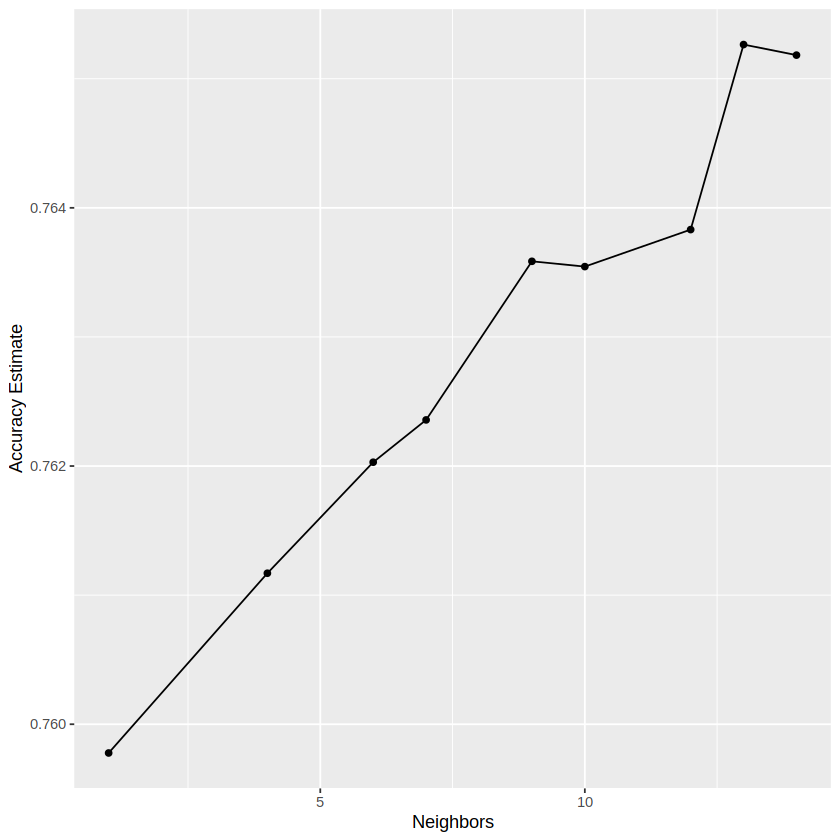

In [6]:
adult_metric_plot <- ggplot(adult_metrics, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate")
adult_metric_plot

adult_min <- adult_metrics |>
filter(neighbors == max(neighbors))
       
a_min <- adult_min |> pull(neighbors)

a_min